In [2]:
import numpy as np
import time
import numpy as np

from envs.game2048_env import * 
import random
from tqdm import tqdm

from matplotlib import pyplot as plt

In [ ]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [3]:

class Game2048Env_TD(Game2048Env):

    def __init__(self):
        super().__init__()
        #self.tile = np.zeros((4, 4), dtype = np.uint32)
        self.set_max_tile(2048)
         # Initialise seed
        self.seed()
        # Reset ready for a game
        self.reset()            

    def GenRandTile(self, prev_reward):
        if prev_reward == -1:
            return       
        self.add_tile()

    def copyBoard(self, tmp):
        self.Matrix = tmp.get_board().copy()	
    
    def getTile(self, pos):
        if not self.Matrix[pos // 4][pos % 4]:
            return 0
        return int(np.log2(self.Matrix[pos // 4][pos % 4]))  

    def move(self, direction, trial=False):
        """Perform one move of the game. Shift things to one side then,
        combine. directions 0, 1, 2, 3 are up, right, down, left.
        Returns the score that [would have] got."""
        if not trial:
            if direction == 0:
                logging.debug("Up")
            elif direction == 1:
                logging.debug("Right")
            elif direction == 2:
                logging.debug("Down")
            elif direction == 3:
                logging.debug("Left")

        changed = False
        move_score = 0
        dir_div_two = int(direction / 2)
        dir_mod_two = int(direction % 2)
        shift_direction = dir_mod_two ^ dir_div_two # 0 for towards up left, 1 for towards bottom right

        # Construct a range for extracting row/column into a list
        rx = list(range(self.w))
        ry = list(range(self.h))

        if dir_mod_two == 0:
            # Up or down, split into columns
            for y in range(self.h):
                old = [self.get(x, y) for x in rx]
                (new, ms) = self.shift(old, shift_direction)
                move_score += ms
                if old != new:
                    changed = True
                    if not trial:
                        for x in rx:
                            self.set(x, y, new[x])
        else:
            # Left or right, split into rows
            for x in range(self.w):
                old = [self.get(x, y) for y in ry]
                (new, ms) = self.shift(old, shift_direction)
                move_score += ms
                if old != new:
                    changed = True
                    if not trial:
                        for y in ry:
                            self.set(x, y, new[y])
        if changed != True:
          return -1
           
        return move_score   
  
   
  
       
    


In [4]:

class TD_Agent():
	def __init__(self, alpha=0.0025):
		self.episode = []
		self.net = []
		self.alpha = alpha
		self.gamma = 1.0
		
	def build_tupleNet(self):
		
		#4 vert
		self.net.append(np.zeros(shape=(12, 12, 12, 12), dtype=np.float32)) #(15, 15, 15, 15)
		self.net.append(np.zeros(shape=(12, 12, 12, 12), dtype=np.float32))
		self.net.append(np.zeros(shape=(12, 12, 12, 12), dtype=np.float32))
		self.net.append(np.zeros(shape=(12, 12, 12, 12), dtype=np.float32))
		#4 hor
		self.net.append(np.zeros(shape=(12, 12, 12, 12), dtype=np.float32)) #(15, 15, 15, 15)
		self.net.append(np.zeros(shape=(12, 12, 12, 12), dtype=np.float32))
		self.net.append(np.zeros(shape=(12, 12, 12, 12), dtype=np.float32))
		self.net.append(np.zeros(shape=(12, 12, 12, 12), dtype=np.float32))

		self.net.append(np.zeros(shape=(12, 12, 12, 12), dtype=np.float32)) #(15, 15, 15, 15)
		self.net.append(np.zeros(shape=(12, 12, 12, 12), dtype=np.float32))
		self.net.append(np.zeros(shape=(12, 12, 12, 12), dtype=np.float32))
		self.net.append(np.zeros(shape=(12, 12, 12, 12), dtype=np.float32))
		self.net.append(np.zeros(shape=(12, 12, 12, 12), dtype=np.float32)) #(15, 15, 15, 15)
		self.net.append(np.zeros(shape=(12, 12, 12, 12), dtype=np.float32))
		self.net.append(np.zeros(shape=(12, 12, 12, 12), dtype=np.float32))
		self.net.append(np.zeros(shape=(12, 12, 12, 12), dtype=np.float32))
		self.net.append(np.zeros(shape=(12, 12, 12, 12), dtype=np.float32))

		
	def load_tupleNet(self, filename):
		for i in range(17):
			self.net.append(np.load(filename+'_'+str(i+1)+".npy"))

	def updateNet(self, tmp, TD_error):
			
			self.net[0][tmp.getTile(0)][tmp.getTile(4)][tmp.getTile(8)][tmp.getTile(12)] += TD_error
			self.net[1][tmp.getTile(1)][tmp.getTile(5)][tmp.getTile(9)][tmp.getTile(13)] += TD_error
			self.net[2][tmp.getTile(2)][tmp.getTile(6)][tmp.getTile(10)][tmp.getTile(14)] += TD_error
			self.net[3][tmp.getTile(3)][tmp.getTile(7)][tmp.getTile(11)][tmp.getTile(15)] += TD_error

			self.net[4][tmp.getTile(0)][tmp.getTile(1)][tmp.getTile(2)][tmp.getTile(3)] += TD_error
			self.net[5][tmp.getTile(4)][tmp.getTile(5)][tmp.getTile(6)][tmp.getTile(7)] += TD_error
			self.net[6][tmp.getTile(8)][tmp.getTile(9)][tmp.getTile(10)][tmp.getTile(11)] += TD_error
			self.net[7][tmp.getTile(12)][tmp.getTile(13)][tmp.getTile(14)][tmp.getTile(15)] += TD_error

			self.net[8][tmp.getTile(0)][tmp.getTile(1)][tmp.getTile(5)][tmp.getTile(4)] += TD_error
			self.net[9][tmp.getTile(1)][tmp.getTile(2)][tmp.getTile(6)][tmp.getTile(5)] += TD_error
			self.net[10][tmp.getTile(2)][tmp.getTile(3)][tmp.getTile(7)][tmp.getTile(6)] += TD_error

			self.net[11][tmp.getTile(4)][tmp.getTile(5)][tmp.getTile(9)][tmp.getTile(8)] += TD_error
			self.net[12][tmp.getTile(5)][tmp.getTile(6)][tmp.getTile(10)][tmp.getTile(9)] += TD_error
			self.net[13][tmp.getTile(6)][tmp.getTile(7)][tmp.getTile(11)][tmp.getTile(10)] += TD_error
			
			self.net[14][tmp.getTile(8)][tmp.getTile(9)][tmp.getTile(13)][tmp.getTile(12)] += TD_error
			self.net[15][tmp.getTile(9)][tmp.getTile(10)][tmp.getTile(14)][tmp.getTile(13)] += TD_error
			self.net[16][tmp.getTile(10)][tmp.getTile(11)][tmp.getTile(15)][tmp.getTile(14)] += TD_error


		

	def getV(self, b):
		v = 0.0
		
		tmp = Game2048Env_TD()
		tmp.copyBoard(b)
		
		v += self.net[0][tmp.getTile(0)][tmp.getTile(4)][tmp.getTile(8)][tmp.getTile(12)] 
		v += self.net[1][tmp.getTile(1)][tmp.getTile(5)][tmp.getTile(9)][tmp.getTile(13)] 
		v += self.net[2][tmp.getTile(2)][tmp.getTile(6)][tmp.getTile(10)][tmp.getTile(14)] 
		v += self.net[3][tmp.getTile(3)][tmp.getTile(7)][tmp.getTile(11)][tmp.getTile(15)] 

		v += self.net[4][tmp.getTile(0)][tmp.getTile(1)][tmp.getTile(2)][tmp.getTile(3)] 
		v += self.net[5][tmp.getTile(4)][tmp.getTile(5)][tmp.getTile(6)][tmp.getTile(7)] 
		v += self.net[6][tmp.getTile(8)][tmp.getTile(9)][tmp.getTile(10)][tmp.getTile(11)] 
		v += self.net[7][tmp.getTile(12)][tmp.getTile(13)][tmp.getTile(14)][tmp.getTile(15)] 

		v += self.net[8][tmp.getTile(0)][tmp.getTile(1)][tmp.getTile(5)][tmp.getTile(4)] 
		v += self.net[9][tmp.getTile(1)][tmp.getTile(2)][tmp.getTile(6)][tmp.getTile(5)] 
		v += self.net[10][tmp.getTile(2)][tmp.getTile(3)][tmp.getTile(7)][tmp.getTile(6)] 

		v += self.net[11][tmp.getTile(4)][tmp.getTile(5)][tmp.getTile(9)][tmp.getTile(8)] 
		v += self.net[12][tmp.getTile(5)][tmp.getTile(6)][tmp.getTile(10)][tmp.getTile(9)] 
		v += self.net[13][tmp.getTile(6)][tmp.getTile(7)][tmp.getTile(11)][tmp.getTile(10)] 
		
		v += self.net[14][tmp.getTile(8)][tmp.getTile(9)][tmp.getTile(13)][tmp.getTile(12)] 
		v += self.net[15][tmp.getTile(9)][tmp.getTile(10)][tmp.getTile(14)][tmp.getTile(13)] 
		v += self.net[16][tmp.getTile(10)][tmp.getTile(11)][tmp.getTile(15)][tmp.getTile(14)] 

		return v




	def Episode_begin(self):
		self.episode = []
		
	def Episode_end(self):
		last = True
		while len(self.episode) > 0:
			a = self.episode[-1]['after']
			b = self.episode[-1]['before']
			R = self.episode[-1]['reward']
			S_, S = self.getV(a), self.getV(b)
			tmp = Game2048Env_TD()
			tmp.copyBoard(b)
			if last == False:
				self.updateNet(b, self.alpha*(R + S_ - S))
			else:
				self.updateNet(b, self.alpha*(0 - S))
			last = False
			del self.episode[-1]

	def end_game(self,b):
		tmp = Game2048Env_TD()
		tmp.copyBoard(b)
		if tmp.move(0) == -1 and tmp.move(0) == tmp.move(1) and tmp.move(1) == tmp.move(2) and tmp.move(2) == tmp.move(3):
			return True
		else:
			return False
		
	def step(self, prev):		
		
		maxV = float(-1e9)
		maxOP = -1

		tmp = Game2048Env_TD()
		
		for op in range(4):
			tmp.copyBoard(prev)
			r = tmp.move(op)
			
			if r != -1:
				v = self.getV(tmp)
				if v+r >= maxV:
					maxV = v+r
					maxOP = op
			
		
		if maxOP != -1:
			r = prev.move(maxOP)
			tmp.copyBoard(prev)
			state = {
			'before': tmp,
			'after': tmp,
			'reward': r,
			'action': maxOP
			}
			if len(self.episode) > 0:
				self.episode[-1]['after'] = tmp
			self.episode.append(state)
			return maxOP, r
		else:
			return -1, -1

		




### Training for the first 5000 episodes

In [ ]:


EPISODE = 6000 #1000

AI = TD_Agent(0.005)
print("Building tuple Network...")
AI.build_tupleNet()
print("Completed")

list_scores = []
list_maxscores = []


for e in range(2000):
    B = Game2048Env_TD()
    if e % 100 == 0:
        print("#Episode: {episode}".format(episode = e))
    
    score = 0
    
    while True:
        act, r = AI.step(B)
        max_tile = np.max(B.Matrix)
        score += r
        
        if AI.end_game(B) or score > 50000:
            break
        B.GenRandTile(r)
        if AI.end_game(B):
            break
        #B.printBoard()
    if max_tile>= 1024 :
        print(max_tile)
    
        #B.printBoard()
    list_scores.append(score)
    list_maxscores.append(max_tile)
    

#### Cumulative Reward:

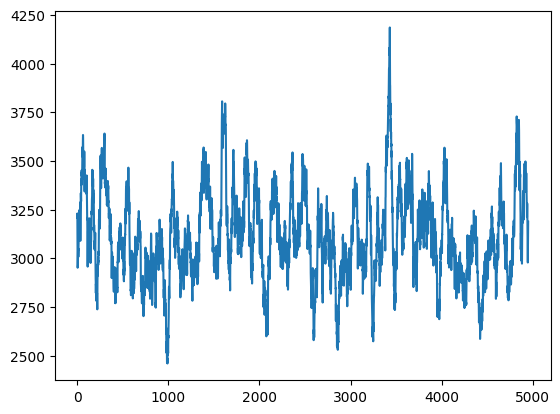

In [29]:
plt.plot(moving_average(list_scores,50))

#### Highest tile value:

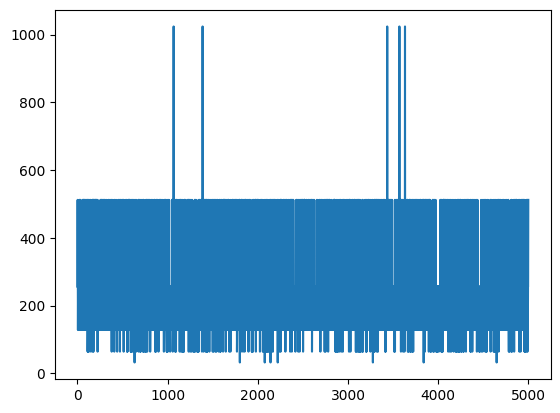

In [30]:
plt.plot(list_maxscores)

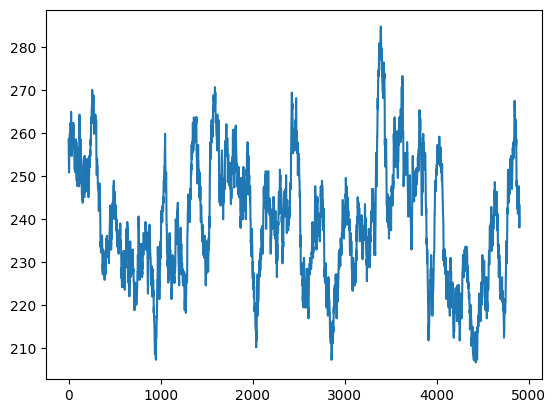

In [33]:
plt.plot(moving_average(list_maxscores,100))

### Saving scores and weightes to disk to relaod for further training: 

In [5]:
print('saving scores')
np.save('scores_5000.npy',np.array(list_scores))

print('saving max scores')
np.save('maxscores_5000.npy',np.array(list_maxscores))


print('saving weights')
for i in range(17):
    np.save("agent/tuple%d" % (i+1), AI.net[i])